In [134]:
# import packages
import seaborn as sns
import numpy as np
from scipy.io import loadmat
import pandas as pd
import json

# define paths
results_dir = "/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/results/results_20220901/";
outpath = "/home/d9smith/projects/random_effects/behavioral/results/plots/";

In [25]:
params = loadmat(results_dir + 'model_parameters.mat')

In [27]:
fstem_imaging = [item.astype(str).tolist()[0] for item in params['fstem_imaging'][0]]
titles = [item.astype(str).tolist()[0] for item in params['titles'][0]]


In [112]:
# make RandomEffects an array of arrays
RandomEffects = [[char.astype(str).tolist() for char in item] for item in \
                 [item.ravel().tolist() for item in params['RandomEffects'][0]]]

In [113]:
# not sure whether i need this?
fstem_imaging[14] = 'na'

In [114]:
# set up paths to results files
results_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '.json') for item in fstem_imaging]
sig2mat_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '_sig2mat.json') for item in fstem_imaging]

In [223]:
# define a function for loading results
def load_model(model_file, sig2mat_file, RandomEffects):
    """
    Loads model and sig2mat from specified results files.
    
    arguments:
    model_file     :  path to .json file where FEMA results are stored -- saved from bg_fema_wrapper.m
    sig2mat_file   :  path to .json file where sig2mat is stored -- saved from bg_fema_wrapper.m
    """
    model = pd.read_json(model_file)
    with open(sig2mat_file) as f:
        sig2mat = json.load(f)
    sig2mat = [pd.DataFrame(s, columns = ['est', 'll', 'ul']) for s in sig2mat]
    return model, sig2mat

In [227]:
model1, sig2mat1 = load_model(results_file[0], sig2mat_file[0], RandomEffects[0])
model2, sig2mat2 = load_model(results_file[1], sig2mat_file[1], RandomEffects[1])

In [254]:
for i in range(0,len(RandomEffects[0])-1):
    sig2mat1[i]['param'] = RandomEffects[0][i][0]
sig2mat1

[             est        ll        ul param
 0   1.861891e-02  0.000000  0.113418     F
 1   1.597047e-06  0.000000  0.063843     F
 2   9.413678e-08  0.000000  0.060173     F
 3   7.763962e-02  0.009771  0.156615     F
 4   1.101109e-07  0.000000  0.060459     F
 5   1.916694e-01  0.112563  0.283685     F
 6   4.015486e-02  0.000000  0.123199     F
 7   2.441212e-06  0.000000  0.085437     F
 8   1.425210e-06  0.000000  0.076213     F
 9   1.710894e-01  0.086296  0.269796     F
 10  6.701431e-02  0.000000  0.151298     F
 11  7.003925e-02  0.000000  0.175576     F,
          est        ll        ul param
 0   0.661609  0.574119  0.760794     A
 1   0.162104  0.092408  0.242413     A
 2   0.361693  0.283339  0.451507     A
 3   0.206593  0.130976  0.293373     A
 4   0.421741  0.340758  0.514396     A
 5   0.331266  0.247511  0.426377     A
 6   0.338222  0.260873  0.426640     A
 7   0.690939  0.603539  0.790015     A
 8   0.529776  0.446278  0.624901     A
 9   0.513358  0.426473  0.

In [252]:
len(RandomEffects[0])

3

In [238]:
RandomEffects[0][0][0]
RandomEffects[0][1][0]
RandomEffects[0][2][0]

'E'

<AxesSubplot:xlabel='est', ylabel='est'>

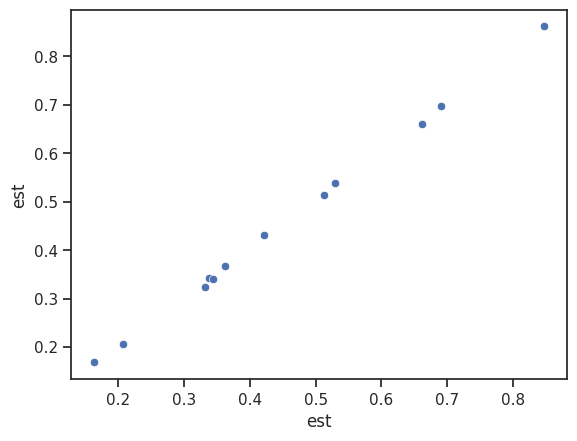

In [220]:
sns.scatterplot(x = sig2mat1[1]['est'], y = sig2mat2[1]['est'])

In [131]:
# function to compare two models
def compare_models(model1, model2, fstem_imaging, titles):
    """
    Visualize FEMA random effects estimates with confidence intervals.
    
    arguments:
    model1          :    model to plot on x axis
    model2          :    model to plot on y axis
    fstem_imaging   :    list of short model names
    titles          :    list of long model names
    
    """
    i = fstem_imaging.index("model1")
    j = fstem_imaging.index("model2")

    

In [145]:
compare_models("model1", "model2", fstem_imaging, titles)

Hello World


In [130]:
# figure 1


Hello World


In [3]:
# figure 2

In [4]:
# figure 3

In [5]:
# figure 4

In [ ]:
# figure 5